## Import Libraries

In [106]:
import pandas as pd

import pickle

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

from sklearn.metrics import accuracy_score

from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


In [225]:
np.random.seed(10)

## Split Data into Training & Test Set

In [5]:
## Import saved dataframe using pickle
df = pd.read_pickle('cleaned_labelled_tweets')

In [17]:
df.head()

,network,datetime,original_tweet,subject,sentiment,lemmatized_tweets_tokens,lemmatized_tweets_string
0,@VodafoneUK,2019-12-04 08:05:14,@VodafoneUK Plus £2.28 package &amp; posting !...,device,0.000000,"[plus, £2.28, package, posting]",plus £2.28 package posting
1,@VodafoneUK,2019-12-04 08:04:05,I have repeatedly asked how to get a refund so...,customer service,-0.300000,"[repeatedly, asked, get, refund, use, another,...",repeatedly asked get refund use another provid...
2,@VodafoneUK,2019-12-04 08:01:19,"I have supplied visa details twice, I have bee...",customer service,-0.300000,"[supplied, visa, detail, twice, subjected, hor...",supplied visa detail twice subjected horrendou...
3,@VodafoneUK,2019-12-04 07:57:42,@VodafoneIN promised yesterday I’d receive no ...,customer service,-0.250000,"[promised, yesterday, receive, call, would, ge...",promised yesterday receive call would get emai...
4,@VodafoneUK,2019-12-04 07:57:16,@VodafoneUK you send texts about rewards - thi...,promotion,-0.155556,"[send, text, reward, morning, lindt, take, app...",send text reward morning lindt take app never ...


In [284]:
df['subject'].value_counts(normalize=True)

other               0.372598
customer service    0.206929
network             0.120000
contract            0.115591
promotion           0.089449
device              0.075591
broadband           0.019843
Name: subject, dtype: float64

In [18]:
X = df['lemmatized_tweets_string']
y = df['subject']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=213)

## Vectorize Data

In [30]:
vectorizer = TfidfVectorizer()

In [54]:
tf_idf_X_train = vectorizer.fit_transform(X_train)

In [55]:
tf_idf_X_test = vectorizer.transform(X_test)

## Model Data

In [64]:
## Function to identify the optimat dataset and parameters for a given classifier and parameter grid
def best_model_parameters_dataset(classifier, param_grid, datasets):
    
    ## Create a list to contain the dataset, optimal parameters, and score for training and test set
    score_parameters = []
    
    ## Create a for loop which iterates through each dataset and identifies the optimal parameters for the given classifier
    for data in datasets:
        
        gs = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=3)
        gs.fit(data['X_train'], data['y_train'])
        y_test_preds = gs.predict(data['X_test'])
        test_score = accuracy_score(y_test_preds, data['y_test'])
        score_parameters.append({'Dataset':data['name'], 'Training Score':round(gs.best_score_,2), 'Test Score': round(test_score,2), 'Parameters':gs.best_params_})
     
    ## Generate a dataframe that contains the optimal parameters for each dataset
    df = pd.DataFrame(score_parameters)
    df.sort_values(by=['Test Score', 'Training Score'], inplace=True, ascending=False)
    
    return df

In [57]:
datasets = [{'name': 'tf_idf','X_train': tf_idf_X_train, 'y_train':y_train, 'X_test': tf_idf_X_test, 'y_test':y_test}]

### K Nearest Neighbours

In [72]:
## Specify the classifier, in this case K nearest neighbours
knn = KNeighborsClassifier()

## Define the parameter grid
knn_param_grid = {'n_neighbors':[5,20,40,50,60],
              'metric': ['manhattan', 'euclidean','minkowski'],
              'weights': ['uniform', 'distance']
             }

In [73]:
best_model_parameters_dataset(knn, knn_param_grid, datasets)

,Dataset,Parameters,Test Score,Training Score
0,tf_idf,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.44,0.4


### Multinomial Naive Bayes Classifier

In [97]:
## Specify the classifier, in this case naive bayes
nb = MultinomialNB()

## Create a parameter grid to identify optimal parameters
nb_param_grid = {'alpha':[0.5,0.8,1]}

In [98]:
best_model_parameters_dataset(nb, nb_param_grid, datasets)

,Dataset,Parameters,Test Score,Training Score
0,tf_idf,{'alpha': 0.5},0.66,0.59


### Multinomial Logistic Regression

In [83]:
## Specify the classifier, in this case LogisticRegression()
logreg = LogisticRegression(random_state=55, max_iter=15000, multi_class='multinomial')

## Create a parameter grid to identify optimal parameters
logreg_param_grid = {'C':[1,2,10],
                     'class_weight': ['balanced', None],
                     'solver':['newton-cg', 'sag', 'saga','lbfgs']}

In [84]:
best_model_parameters_dataset(logreg, logreg_param_grid, datasets)

/Users/isobeldaley/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/isobeldaley/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/isobeldaley/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,Dataset,Parameters,Test Score,Training Score
0,tf_idf,"{'C': 2, 'class_weight': 'balanced', 'solver':...",0.76,0.71


### Random Forest

In [86]:
## Define the classifier to be used, in this case RandomForestClassifier(), specify a random_state
## so that the results are reproducible
forest = RandomForestClassifier(random_state=55)

## Specify the parameter grid to be assessed
forest_param_grid = {'n_estimators': [4,10,50,75,150],
                    'criterion': ['gini', 'entropy'],
                  'max_depth':[None, 5, 10, 15],
                  'class_weight': ['balanced', None],
                  'bootstrap': [True, False]
             }

In [87]:
best_model_parameters_dataset(forest, forest_param_grid, datasets)

,Dataset,Parameters,Test Score,Training Score
0,tf_idf,"{'bootstrap': False, 'class_weight': 'balanced...",0.75,0.68


### Support Vector Machine

In [88]:
## Specify the classification model, in this case a support vector machine
svm = SVC(gamma='auto', random_state=55)

## Specify the parameter grid to be used during the GridSearchCV
svm_param_grid = {'C':[1,5,10],
                'class_weight':['balanced', None]}

In [90]:
best_model_parameters_dataset(svm, svm_param_grid, datasets)

,Dataset,Parameters,Test Score,Training Score
0,tf_idf,"{'C': 1, 'class_weight': None}",0.4,0.37


### XG Boost

In [101]:
## Specify the classifier, in this case XG Boost
boost = xgb.XGBClassifier()

## Fit the model using the training data
boost.fit(tf_idf_X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [103]:
## Create predictions for the training and test datasets
boost_preds_train = boost.predict(tf_idf_X_train)
boost_preds_test = boost.predict(tf_idf_X_test)

In [104]:
accuracy_score(y_train, boost_preds_train)

0.7803149606299212

In [105]:
accuracy_score(y_test, boost_preds_test)

0.6992125984251969

### Neural Network

In [245]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.layers import Dropout

In [167]:
le = LabelEncoder()
le.fit(df['subject'])
tweet_category = le.transform(df['subject'])
tweet_category

array([3, 2, 2, ..., 6, 6, 4])

In [168]:
tweet_onehot = to_categorical(tweet_category)
tweet_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [171]:
tweets = df['lemmatized_tweets_string']

In [174]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(tweets)
tokenized_X = tokenizer.texts_to_matrix(tweets,mode='binary')

In [316]:
X_train, X_test, y_train, y_test = train_test_split(tokenized_X,tweet_onehot,test_size=0.2, random_state=213)

In [317]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2, random_state=213)

In [332]:
epochs=20
learning_rate = 0.2
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)

In [333]:
model = models.Sequential()

In [334]:
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) 
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [335]:
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [322]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=200, validation_data=(X_val, y_val))

Train on 2032 samples, validate on 508 samples
Epoch 1/20
2032/2032 [==============================] - 0s 244us/step - loss: 1.7992 - accuracy: 0.3342 - val_loss: 1.6694 - val_accuracy: 0.3740
Epoch 2/20
2032/2032 [==============================] - 0s 26us/step - loss: 1.6519 - accuracy: 0.3661 - val_loss: 1.5706 - val_accuracy: 0.4213
Epoch 3/20
2032/2032 [==============================] - 0s 29us/step - loss: 1.4904 - accuracy: 0.4744 - val_loss: 1.3763 - val_accuracy: 0.5236
Epoch 4/20
2032/2032 [==============================] - 0s 28us/step - loss: 1.1964 - accuracy: 0.5989 - val_loss: 1.1734 - val_accuracy: 0.6161
Epoch 5/20
2032/2032 [==============================] - 0s 29us/step - loss: 0.9385 - accuracy: 0.6924 - val_loss: 1.2204 - val_accuracy: 0.6339
Epoch 6/20
2032/2032 [==============================] - 0s 26us/step - loss: 0.7757 - accuracy: 0.7451 - val_loss: 1.4377 - val_accuracy: 0.5787
Epoch 7/20
2032/2032 [==============================] - 0s 29us/step - loss: 0.664

In [192]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

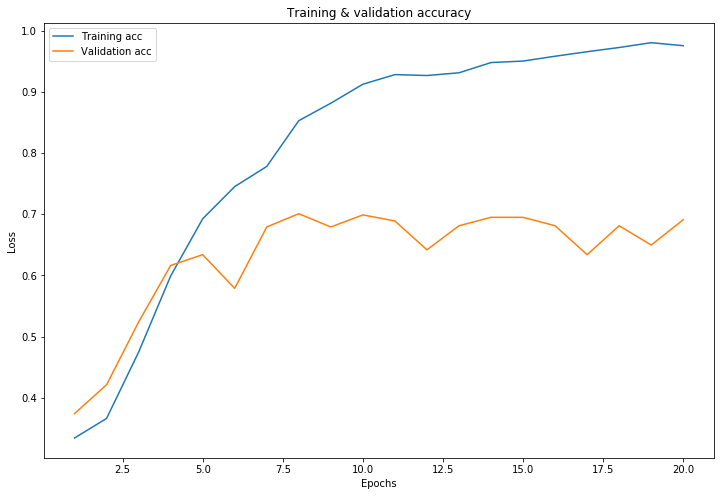

In [323]:
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = history.history['accuracy'] 
val_acc_values = history.history['val_accuracy']
epochs = range(1,21)

ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [324]:
preds = model.predict_classes(X_test)

In [325]:
accuracy_score(decoded_y_test, preds)

0.6992125984251969

In [210]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [272]:
def decode(datum):
    return np.argmax(datum)

In [274]:
decoded_y_test = []
for i in range(y_test.shape[0]):
    decoded_y_test.append(decode(y_test[i]))
    

[5,
 5,
 6,
 5,
 2,
 5,
 4,
 1,
 1,
 5,
 5,
 5,
 5,
 5,
 2,
 2,
 5,
 2,
 1,
 2,
 5,
 5,
 3,
 6,
 1,
 5,
 1,
 3,
 5,
 1,
 4,
 6,
 3,
 2,
 2,
 5,
 2,
 5,
 6,
 5,
 3,
 4,
 4,
 2,
 4,
 2,
 3,
 5,
 1,
 2,
 1,
 5,
 4,
 5,
 2,
 2,
 2,
 5,
 1,
 2,
 5,
 2,
 4,
 4,
 2,
 3,
 5,
 2,
 5,
 6,
 2,
 2,
 3,
 5,
 5,
 5,
 1,
 1,
 5,
 5,
 4,
 2,
 2,
 2,
 1,
 4,
 2,
 1,
 3,
 4,
 5,
 3,
 6,
 5,
 5,
 1,
 4,
 2,
 1,
 3,
 2,
 2,
 1,
 3,
 3,
 5,
 1,
 3,
 5,
 6,
 5,
 1,
 4,
 5,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 5,
 1,
 1,
 2,
 2,
 5,
 2,
 4,
 3,
 5,
 5,
 5,
 2,
 1,
 5,
 2,
 5,
 6,
 5,
 5,
 1,
 5,
 1,
 6,
 2,
 2,
 1,
 5,
 5,
 5,
 3,
 5,
 1,
 5,
 5,
 5,
 5,
 2,
 1,
 2,
 5,
 6,
 5,
 1,
 6,
 6,
 4,
 4,
 2,
 0,
 6,
 4,
 2,
 3,
 4,
 2,
 5,
 6,
 5,
 5,
 4,
 5,
 5,
 3,
 1,
 1,
 5,
 1,
 3,
 2,
 5,
 5,
 2,
 3,
 5,
 2,
 5,
 5,
 6,
 1,
 1,
 5,
 4,
 5,
 4,
 1,
 5,
 5,
 5,
 4,
 1,
 5,
 1,
 1,
 5,
 2,
 2,
 4,
 5,
 5,
 3,
 4,
 5,
 6,
 5,
 6,
 5,
 6,
 6,
 2,
 5,
 2,
 5,
 2,
 5,
 5,
 1,
 5,
 5,
 1,
 2,
 3,
 2,
 5,
 1,
 5,
 1,
 3,
 2,


## Label Unlabelled Data

In [305]:
unlabelled_df = pd.read_pickle('cleaned_unlabelled_tweets')

In [306]:
unlabelled_df.head()

,network,datetime,original_tweet,subject,sentiment,lemmatized_tweets_tokens,lemmatized_tweets_string
39,@VodafoneUK,2019-12-04 01:20:56,@avipan_lko @VodafoneIN @VodafoneGroup @Vodafo...,,0.0,[],
41,@VodafoneUK,2019-12-04 00:48:17,@danielrome18 @VodafoneUK fucking hell 😱,,-0.6,"[fucking, hell]",fucking hell
56,@VodafoneUK,2019-12-03 22:46:47,@VodafoneUK I was hoping you’d say that.,,0.0,"[hoping, youd, say]",hoping youd say
61,@VodafoneUK,2019-12-03 22:38:07,@VodafoneUK please explain https://t.co/PhHJdM...,,0.0,"[please, explain]",please explain
65,@VodafoneUK,2019-12-03 22:22:46,"@Townsley85 @VodafoneUK Hear, hear!",,0.0,"[hear, hear]",hear hear


In [307]:
unlabelled_tweets = unlabelled_df['lemmatized_tweets_string']

In [308]:
unlabelled_X = tokenizer.texts_to_matrix(unlabelled_tweets,mode='binary')

In [309]:
preds = model.predict_classes(unlabelled_X)

In [310]:
preds_onehot = to_categorical(preds)
preds_onehot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [327]:
X = np.append(arr=X_train, values=unlabelled_X, axis=0)

In [326]:
y = np.append(arr=y_train, values=preds_onehot, axis=0)

In [330]:
len(y)

11428

## Re-Run Model

In [336]:
history = model.fit(X,
                    y,
                    epochs=epochs,
                    batch_size=200, validation_data=(X_val, y_val))

Train on 11428 samples, validate on 508 samples
Epoch 1/20
11428/11428 [==============================] - 1s 62us/step - loss: 1.2724 - accuracy: 0.5661 - val_loss: 1.0215 - val_accuracy: 0.6319
Epoch 2/20
11428/11428 [==============================] - 0s 19us/step - loss: 0.6440 - accuracy: 0.7813 - val_loss: 0.7826 - val_accuracy: 0.7579
Epoch 3/20
11428/11428 [==============================] - 0s 19us/step - loss: 0.4076 - accuracy: 0.8564 - val_loss: 0.7803 - val_accuracy: 0.7795
Epoch 4/20
11428/11428 [==============================] - 0s 19us/step - loss: 0.2837 - accuracy: 0.9004 - val_loss: 0.7563 - val_accuracy: 0.7894
Epoch 5/20
11428/11428 [==============================] - 0s 19us/step - loss: 0.2031 - accuracy: 0.9277 - val_loss: 0.9918 - val_accuracy: 0.7835
Epoch 6/20
11428/11428 [==============================] - 0s 20us/step - loss: 0.1815 - accuracy: 0.9357 - val_loss: 0.9270 - val_accuracy: 0.7795
Epoch 7/20
11428/11428 [==============================] - 0s 20us/step

In [338]:
preds = model.predict_classes(X_test)

In [339]:
accuracy_score(decoded_y_test, preds)

0.7133858267716535